# Multispektral MRI (e) - Ikke-styrt (k-means) vevsklassifikasjon 

 Versjon 13.01.2020 A. Lundervold  (**Under construction**)

**DATA**

We will be using a four-channel multispectral image (slice 60 from a multispectral 3D recording),  <br>
reported in  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
and a manually delineated `brain ROI mask` for spatial restriction of the unsupervised pixel classification

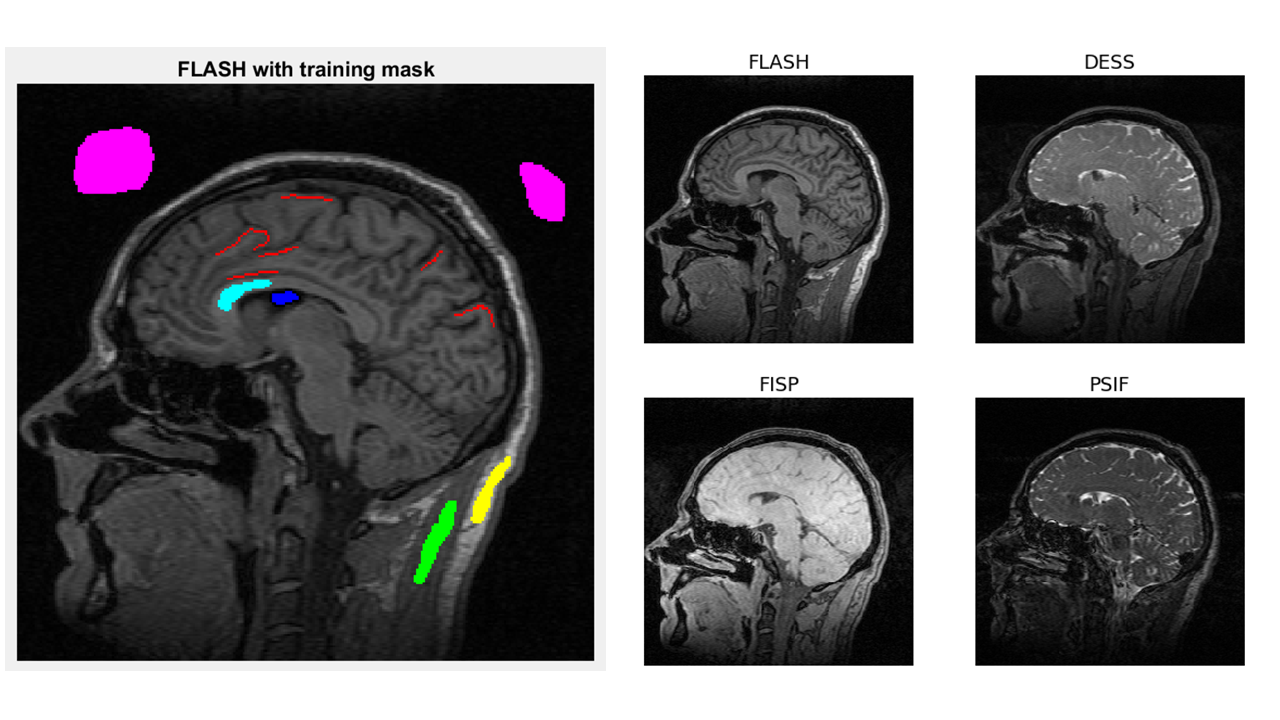

In [1]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

**Import libraries to be used**

In [2]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
#import joblib
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

**Define directory with the data and the channel names (MRI pulse sequence acronyms)**

In [3]:
mytestdata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']

## Read the multispectral MR image and the binary ROI mask

In [4]:
# Using nibabel to read the multispectral image (and the ROI mask)
fn_multispectral = '../data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

**Print properties of the multispectral NIFTI image**

In [5]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
dat = img.get_fdata()
print('min = %.1f' % dat.min())
print('max = %.1f' % dat.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
data = np.uint16(dat.squeeze())
print('shape of 2D+spectral data = ',data.shape)
print('dtype of 2D+spectral data = ',data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral data =  (256, 256, 4)
dtype of 2D+spectral data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**Display the multispectral MR image**

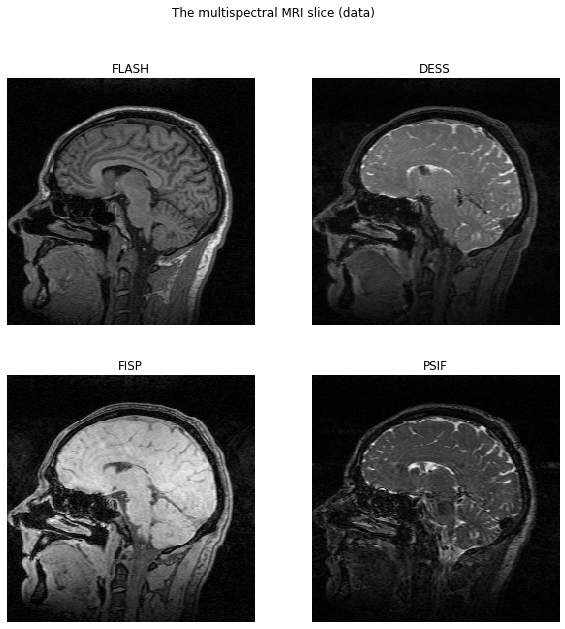

In [6]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (data)") 
plt.tight_layout
plt.show()

### Constructing a Pandas data frame from the MRI data (img) and the ROI mask (roimsk)

In [7]:
roimsk_data = roimsk.get_fdata().squeeze()
# roimsk_data = np.ones(roimsk_data.shape)   # Using the whole image as ROI
roimsk_data.shape

(256, 256)

Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfR)

In [8]:
# Find pixel locations (ind_roi) corresponding to brain ROI (value 1 inside ROI, 0 else) 
ind_roi = np.where(roimsk_data == 1) 
X = np.asarray(data[ind_roi[0][:],ind_roi[1][:],:]) # The multispectral signal intensities
dfR = pd.DataFrame(X, columns = chn_names)
dfR.insert(loc = len(dfR.columns),
           column = 'row',
           value = ind_roi[0])  # Row of pixel location
dfR.insert(loc = len(dfR.columns),
           column = 'col',
           value = ind_roi[1])  # Col of pixel location

In [9]:
X.shape

(35822, 4)

In [10]:
dfR.head()

,FLASH,DESS,FISP,PSIF,row,col
0,149,66,67,66,20,121
1,129,90,86,106,20,122
2,101,83,146,81,20,123
3,28,79,158,40,20,124
4,7,53,155,67,20,125


In [11]:
dfR.tail()

,FLASH,DESS,FISP,PSIF,row,col
35817,10,13,29,6,239,150
35818,8,18,29,6,239,151
35819,12,18,20,8,239,152
35820,0,20,25,16,239,153
35821,9,26,19,19,239,154


### OPTIONAL: Scaling* of feature vectors  (MRI signal inensity), channel-by-channel wthin the ROI mask

*) Scaling to zero mean and unit standard deviation

In [12]:
scaler = StandardScaler()  
scaler.fit(X.astype(float))

X_scaled = scaler.transform(X.astype(float))  

# Make data frame from scaled X_train og y_train to check scaling
dX_scaled = pd.DataFrame(X_scaled, columns=chn_names)
dy = pd.concat([dfR.row, dfR.col], axis=1)
X_scaled = pd.concat([dX_scaled, dy], axis=1)
X_scaled.head()

,FLASH,DESS,FISP,PSIF,row,col
0,1.107765,-0.118564,-0.557741,-0.343962,20,121
1,0.763861,0.362309,-0.295802,0.257753,20,122
2,0.282395,0.222054,0.531375,-0.118319,20,123
3,-0.972856,0.141909,0.696810,-0.735078,20,124
4,-1.333956,-0.379037,0.655451,-0.328920,20,125


In [13]:
X_scaled.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
FLASH,35822.0,0.0000,1.0000,-1.4543,0.1620,4.6844
DESS,35822.0,0.0000,1.0000,-1.4410,-0.1186,4.5299
FISP,35822.0,-0.0000,1.0000,-1.4814,0.0626,2.0754
PSIF,35822.0,-0.0000,1.0000,-1.3368,0.0321,6.0794
row,35822.0,134.5855,56.4481,20.0000,136.0000,239.0000
col,35822.0,142.2969,50.9810,42.0000,142.0000,240.0000


## Unsupervised classification of multispectral MRI using K-means

In [14]:
X.shape  # n x p data matrix, n=samples, p = feature vector dimension

(35822, 4)

> # Start your experiments here:
(Make a copy of the original notebook and name it<br> e.g. 
`my_ELMED219-Lab2-Del2e-MRI-Ikke-Styrt-Vevsklassifikasjon.ipynb`)

### Clustering the 4D multispectral data within the ROI mask 
####  LATER: _play with different values of `K`, `max_iter` and `tol`_

In [15]:
K = 16  # Number of clusters
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [16]:
# Fit the K-means model to the data
kmeans_fit = kmeans_model.fit(X)

In [17]:
print(kmeans_fit.labels_)
print('First centroid i p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[11 11  4 ...  5  5  5]
First centroid i p-dimensional feature vector space:
 [28.79835516 23.17362169 32.79835516 39.60310691]


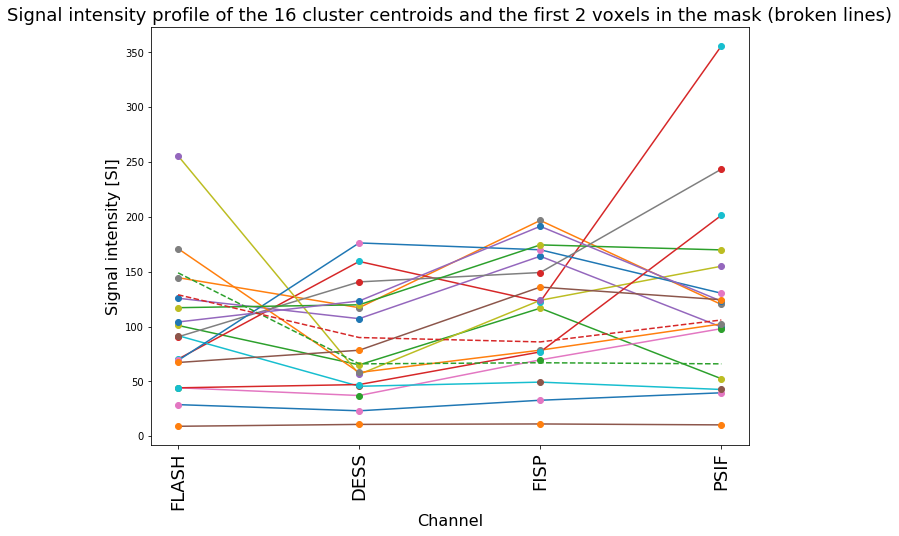

In [18]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, 'o')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(len(chn_names))])
ax.set_xticklabels(chn_names, rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Signal intensity profile of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**OPTIONAL:** Fit the K-means model to the scaled data

In [19]:
# Fit the K-means model to the scaled data
# kmeans_model_scaled = KMeans(n_clusters=K, random_state=42)
# kmeans_fit_scaled = kmeans_model_scaled.fit(X_scaled)

In [20]:
# print(kmeans_fit_scaled.labels_)
# print('First centroid in scaled p-dimensional feature vector space:\n', kmeans_fit_scaled.cluster_centers_[0,:])

#### Make a k-means segmented image (segmentation restricted to the ROI)

In [21]:
kmeans_segm = 0 * roimsk_data.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (256, 256)
min: 0
max: 15
Number of clustered samples within ROI: 35822


#### Assign the cluster belonging to each voxel within the ROI

In [22]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v]] = kmeans_fit.labels_[v]

**and dsiplay the result (comparing with the FLASH channel)**

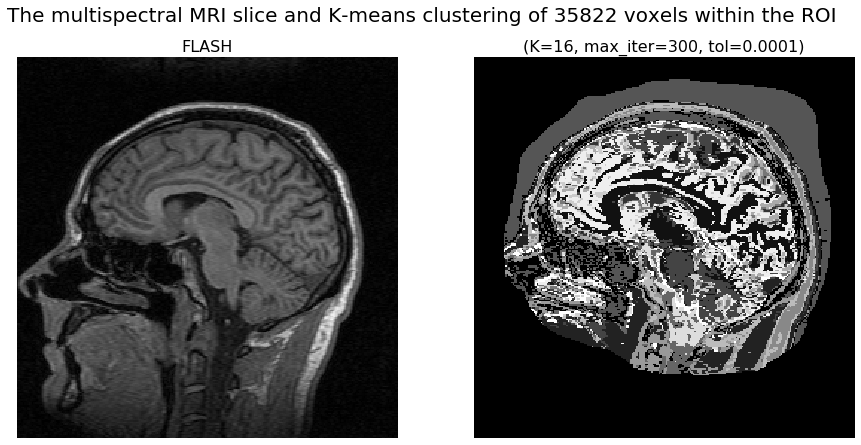

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0], fontsize=16)
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap='gray', origin='lower')
ax[1].set_title('(K=%d, max_iter=%d, tol=%.4f)' % (K, max_iter, tol), fontsize=16)
ax[1].axis('off')
plt.suptitle('The multispectral MRI slice and K-means clustering of %d voxels within the ROI' % (X.shape[0]), fontsize=20) 
plt.tight_layout
plt.show()

**Design a new [colormap](https://matplotlib.org/tutorials/colors/colormap-manipulation.html) for the clustering, using [named colors](https://matplotlib.org/examples/color/named_colors.html) and gray levels, a colorcode 
[dictionary](https://www.geeksforgeeks.org/python-dictionary)**

In [24]:
import matplotlib
col_code = {
    'CLU0': [255,255,255], # White (background)
    'CLU1': [255,0,255],   # Magenta 
    'CLU2': [255,0,0],     # Red 
    'CLU3': [0,255,255],   # Cyan 
    'CLU4': [0,0,255],     # Blue 
    'CLU5': [0,255,0],     # Green 
    'CLU6': [255,255,0],   # Yellow 
    'CLU7': [10,10,10],    # Gray levels
    'CLU8': [20,20,20],    
    'CLU10': [40,40,40],
    'CLU11': [80,80,80],     
    'CLU12': [120,120,120],     
    'CLU13': [150,150,150],        
    'CLU14': [180,180,180],  
    'CLU15': [200,200,200]  
}
clu_names = list(col_code.keys())
nclu = len(clu_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
clu_cmap = matplotlib.cm.get_cmap(mycmap, nclu)   # nclu discrete colors

In [25]:
clu_names_num = []
for i in range(nclu):
    str = clu_names[i] + ' [%d]' % (i)
    clu_names_num.append(str)

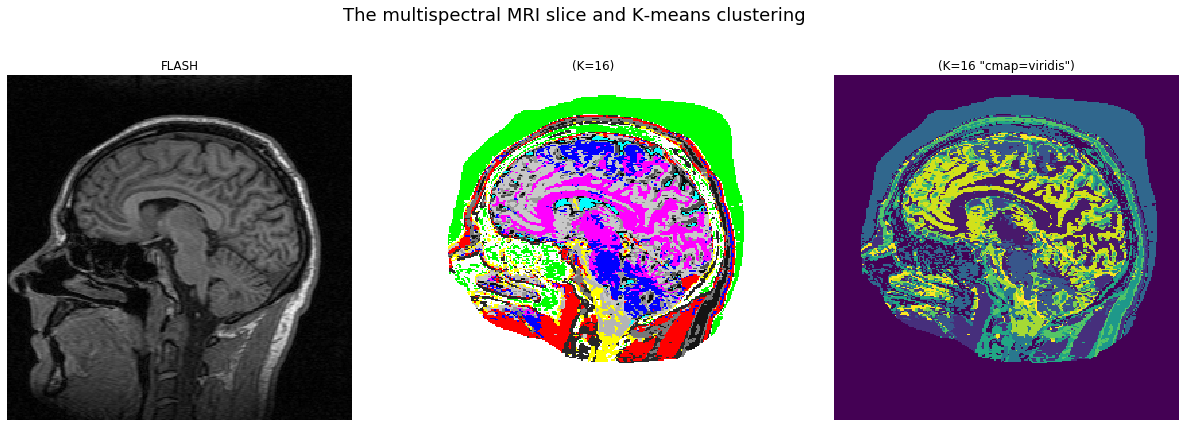

In [26]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0])
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#ax[1].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
#cmsk = ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#clim=cmsk.properties()['clim']
#cbar = fig.colorbar(cmsk, shrink=0.4, label='Cluster [0-%d]' % clim[1])
#cbar.ax.set_yticklabels(clu_names_num)
ax[1].set_title('(K=%d)' % (K))
ax[1].axis('off')
ax[2].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
ax[2].set_title('(K=%d "cmap=viridis")' % (K))
ax[2].axis('off')
plt.suptitle("The multispectral MRI slice and K-means clustering", fontsize=18) 
plt.tight_layout
plt.show()

### 3D scatterplot of clustered (color-coded) featurs vectors and the cluster centroids in 3D feature space

https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook <br>
Using the [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%matplotlib notebook` instead of `%matplotlib inline`

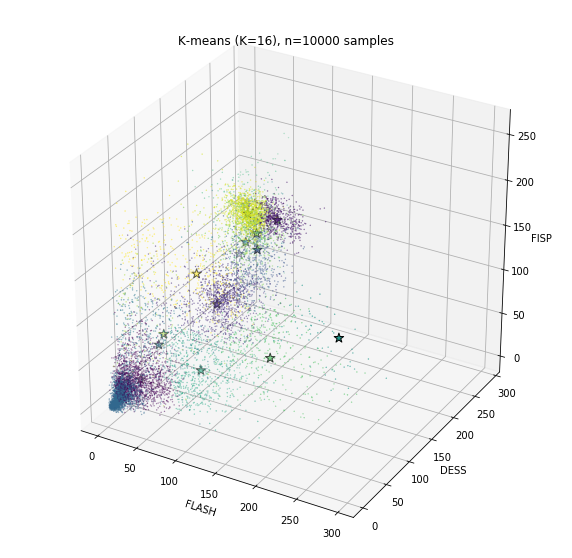

In [27]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

n=10000

xs = X[:n,0]
ys = X[:n,1]
zs = X[:n,2]
c = kmeans_fit.labels_[:n]

ax.scatter(xs, ys, zs, c=c, marker='.', s=0.5)

cxs = kmeans_fit.cluster_centers_[:,0]
cys = kmeans_fit.cluster_centers_[:,1]
czs = kmeans_fit.cluster_centers_[:,2]
cc = range(K)

ax.scatter(cxs, cys, czs, c=cc, marker='*', s=100,  edgecolors = 'black')


ax.set_xlabel('FLASH')
ax.set_ylabel('DESS')
ax.set_zlabel('FISP')

plt.title('K-means (K=%d), n=%d samples' % (K, len(xs)))
plt.show() 

> ### Your turn!
> ## - Play with different values of `K`  (e.g. K=2, ...., 32)
> ## - Try to make biological (or MRI technical) interpretation of the clusters
> ## - Why does the K-means algorithm take longer to converge with increasing K ?
> ## - What does `random_state`do ?
> ## - Play with different values of `max_iter` and `tol` (explain your findings)